In [1]:
# python/package versions
import platform; print('python:',platform.python_version()); del platform # just for version
import numpy as np; print('numpy:',np.__version__)
import matplotlib as mpl; print('matplotlib:',mpl.__version__)
import scipy as sci; print('scipy:',sci.__version__)

python: 3.12.4
numpy: 1.26.4
matplotlib: 3.8.4
scipy: 1.13.1


In [2]:
# additional imports
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_lyapunov
import numpy.random as rnd
from time import perf_counter

import CDC2024 as c24

In [3]:
# package options
np.set_printoptions(precision=5,suppress=True)
plt.rc('axes',grid=True,axisbelow=True)

# trick to make PDF outputs of figs acceptable for IEEE submission
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# overall notebook run timer
ovt0 = perf_counter()

Flat smooth bump function $\mathcal{B}(x)$, shown here as defined using parameters $a_\mathcal{B}=-12,b_\mathcal{B}=-10,c_\mathcal{B}=10,d_\mathcal{B}=12$:  
(see https://en.wikipedia.org/wiki/Non-analytic_smooth_function#Smooth_transition_functions )

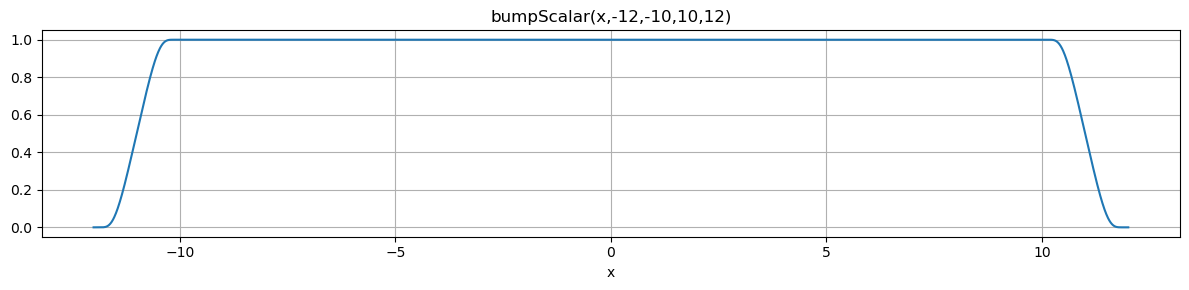

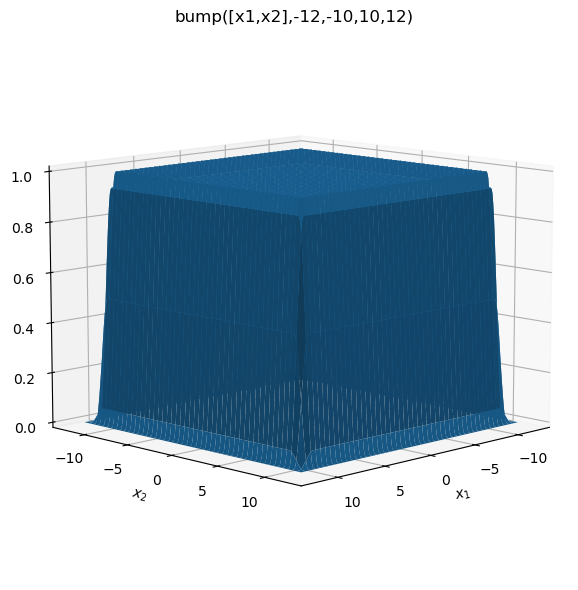

In [4]:
# c24.plotFunc(c24.f_bump,xmin=-10,xmax=10,xN=2001,pltTitle='f(x)') # component of bump func
# c24.plotFunc(c24.g_bump,xmin=-10,xmax=10,xN=2001,pltTitle='g(x)') # component of bump func

aBump = -12
bBump = -10
cBump = 10
dBump = 12

bumpScalar = c24.set_bumpScalar_func(aBump,bBump,cBump,dBump)
c24.plotFunc(bumpScalar,xmin=-12,xmax=12,xN=2401,pltTitle='bumpScalar(x,%d,%d,%d,%d)'%(aBump,bBump,cBump,dBump))

# %matplotlib qt
bumpX = c24.set_bumpX_func([bumpScalar,bumpScalar])
c24.pltFunc3d(bumpX,xmin=-12,xmax=12,xN=241,pltTitle='bump([x1,x2],%d,%d,%d,%d)'%(aBump,bBump,cBump,dBump))

We defined the platform's true dynamics as:  

$$
\begin{align*}
    \dot{x}_t &= A\ x_t + B\ \Lambda \left(u_t + f(x_t)\right) \\
              &= A\ x_t + B\ \Lambda \left(u_t + \Theta\ \Psi(x_t)\right) \\
    \begin{bmatrix} \dot{\vartheta}_t \\ \dot{p}_t \end{bmatrix} &= 
    \begin{bmatrix} 0 & 1 \\ a_1 & a_2 \end{bmatrix}
    \begin{bmatrix} \vartheta_t \\ p_t \end{bmatrix}
    + \begin{bmatrix} 0 \\ 1 \end{bmatrix}\beta
    \left( u_t + 
        %   \begin{bmatrix} \dfrac{\theta_1}{\beta} & \dfrac{\theta_2}{\beta} & \dfrac{\theta_3}{\beta} \end{bmatrix}
          \begin{bmatrix} \theta_1 & \theta_2 & \theta_3 \end{bmatrix}
          \begin{bmatrix} \mathcal{B}\!\left(x_t\right) \vartheta_t^2\ p_t  \\ 
            \mathcal{B}\!\left(x_t\right) |p_t|\,p_t \\ 
            \mathcal{B}\!\left(x_t\right) \varphi_t^3 \end{bmatrix} \right) \\
    \begin{bmatrix} \dot{\vartheta}_t \\ \dot{p}_t \end{bmatrix} &= 
    \begin{bmatrix} 0 & 1 \\ -2 & 1 \end{bmatrix}
    \begin{bmatrix} \vartheta_t \\ p_t \end{bmatrix}
    + \begin{bmatrix} 0 \\ 1 \end{bmatrix} 0.75
    \left( u_t + 
        %   \begin{bmatrix} \dfrac{\theta_1}{\beta} & \dfrac{\theta_2}{\beta} & \dfrac{\theta_3}{\beta} \end{bmatrix}
          \begin{bmatrix} -0.08267 & 0.012 & 0.028 \end{bmatrix}
          \begin{bmatrix} \mathcal{B}\!\left(x_t\right) \vartheta_t^2\ p_t  \\ 
            \mathcal{B}\!\left(x_t\right) |p_t|\,p_t \\ 
            \mathcal{B}\!\left(x_t\right) \varphi_t^3 \end{bmatrix} \right)
\end{align*} \\
$$

with $a_1=-2, a_2=1, \beta=0.75, \theta_1=-0.08267, \theta_2=0.012,$ and $\theta_3=0.028$

In [5]:
# these values are directly from Lavretsky 2013 textbook on MRAC chapter 9.5, example 9.3
# a1 = -0.018  # Lavretsky "theta_1"
# a2 = 0.015  # Lavretsky "theta_2"
beta = 0.75  # Lavretsky "theta_3"
theta1 = -0.08267  # Lavretsky "theta_4"
theta2 = 0.012  # Lavretsky "theta_5"
theta3 = 0.028  # Lavretsky "theta_6"

# these values for the A matrix we used in the CDC 2022 paper example, which was 
# a more modified version of the Lavretsky example 9.3 dynamics
#
# they give similar unstable oscillatory state behavior, but with faster action
a1 = -2
a2 = 1

A,BL = c24.setPlatformTrueLinearDyn(a1,a2,beta)
Theta,PsiFunc,ThetaPsiFunc = c24.setPlatformNonlinearity(theta1, theta2, theta3, bumpX)
PsiNBFunc,ThetaPsiNBFunc = c24.setPlatformNLnoBump(theta1, theta2, theta3) # version without bump function

A:
 [[ 0  1]
 [-2  1]] (2, 2)
eig: [0.5-1.32288j 0.5+1.32288j]
B Lambda:
 [[0.  ]
 [0.75]] (2, 1)
Theta:
 [[-0.08267  0.012    0.028  ]] (1, 3)
Psi shape: (3, 1)
ThetaPsi shape: (1, 1)
ThetaPsiNB shape: (1, 1)


The linear component of the true platform dynamics is unstable.  

Simulation with no control from initial $x_0=\begin{bmatrix} 0.1 \\ 0 \end{bmatrix} $:

time steps: [ 0.     0.001  0.002 ...  9.998  9.999 10.   ] (10001,)
Euler integration simulation time: 0.1 sec



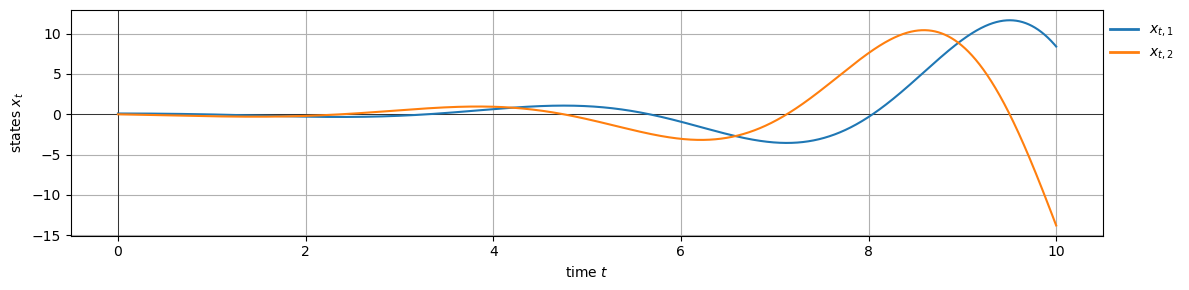

In [6]:
c24.simLinearUncontrolled(A,t0 = 0,tf = 10,dt = 0.001, x0=[0.1,0.])

Adding the nonlinear component to the uncontrolled simulation, from the same initial conditions:

time steps: [ 0.     0.001  0.002 ...  9.998  9.999 10.   ] (10001,)
Euler integration simulation time: 1.4 sec



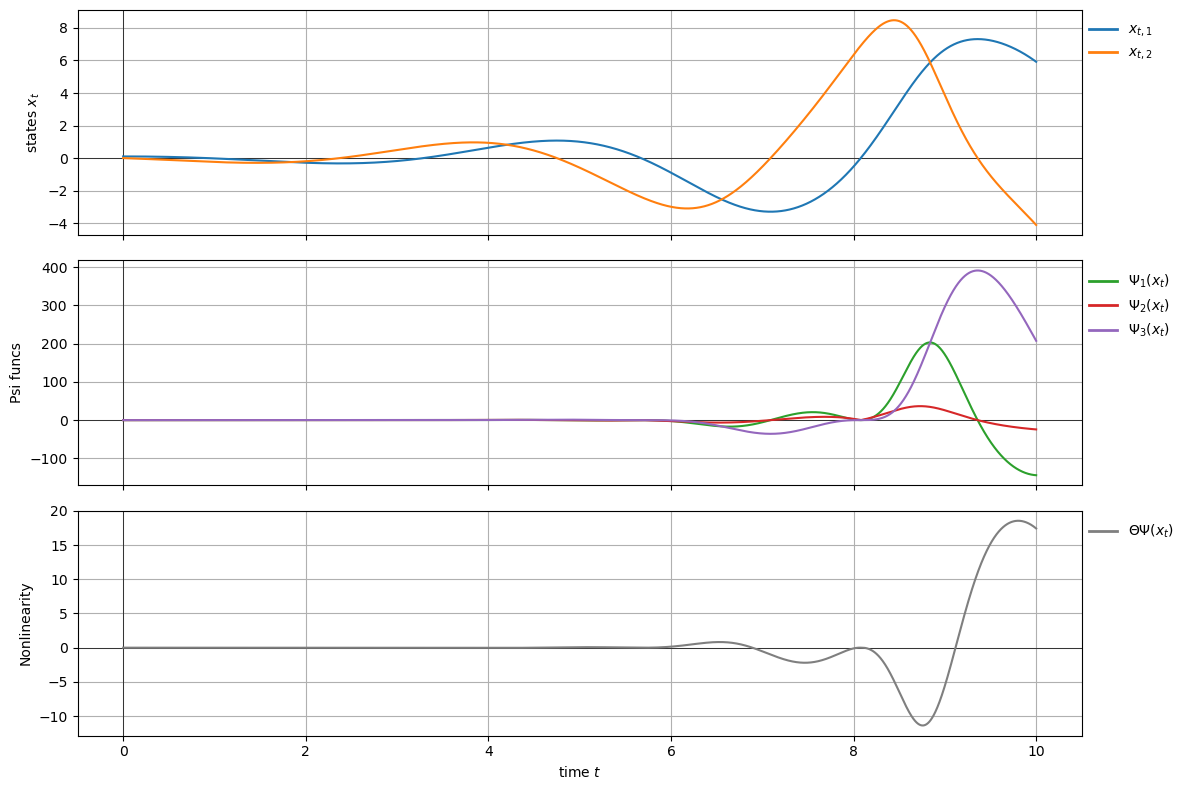

In [7]:
c24.simFullUncontrolled(A,BL,beta,PsiFunc,ThetaPsiFunc,t0 = 0,tf = 10,dt = 0.001, x0=[0.1,0.])

Note at the final sim time above, the $\mathcal{B}(x_t)$ have not yet saturated. And so this is no different than
the uncontrolled nonlinear sim using no $\mathcal{B}(x_t)$ bump functions at all:

time steps: [ 0.     0.001  0.002 ...  9.998  9.999 10.   ] (10001,)
Euler integration simulation time: 0.2 sec



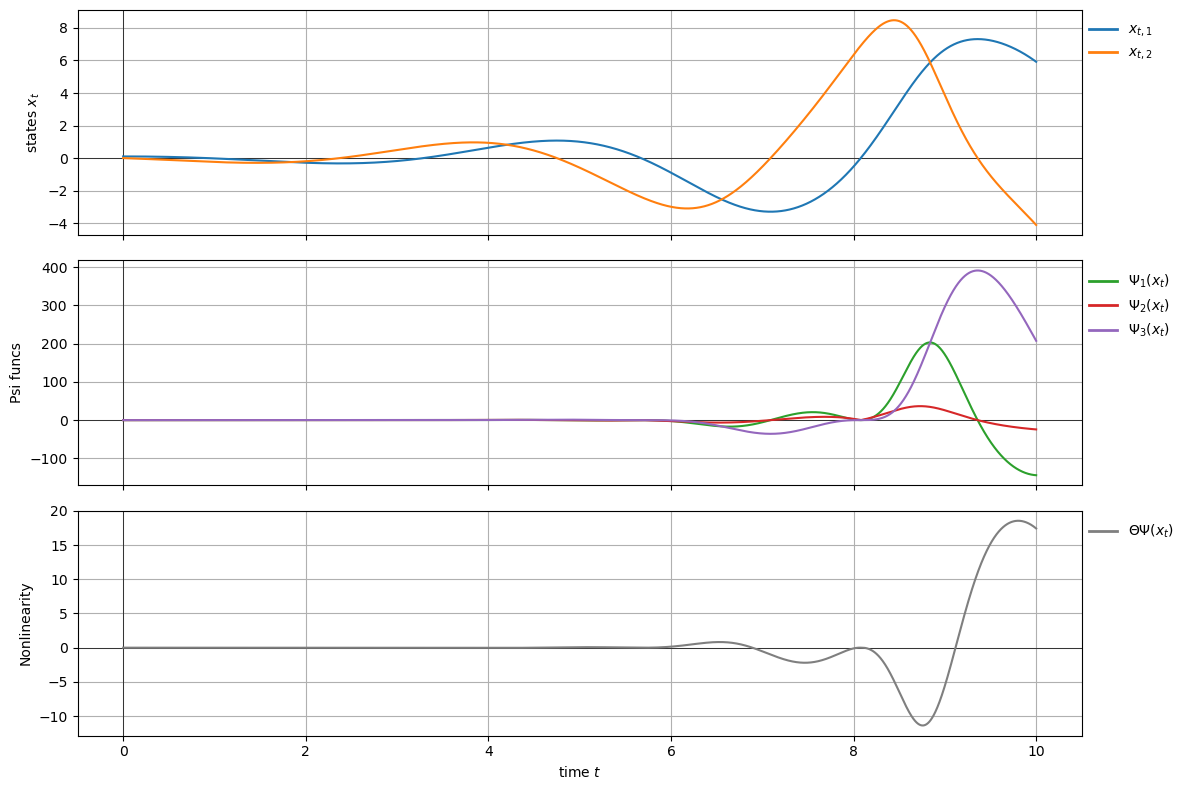

In [8]:
c24.simFullUncontrolled(A,BL,beta,PsiNBFunc,ThetaPsiNBFunc,t0 = 0,tf = 10,dt = 0.001, x0=[0.1,0.])

If we let the uncontrolled sim go longer, the states reach the saturation point and the $\mathcal{B}(x_t)$ functions smoothly cut off:

time steps: [ 0.     0.001  0.002 ... 14.998 14.999 15.   ] (15001,)
Euler integration simulation time: 2.1 sec



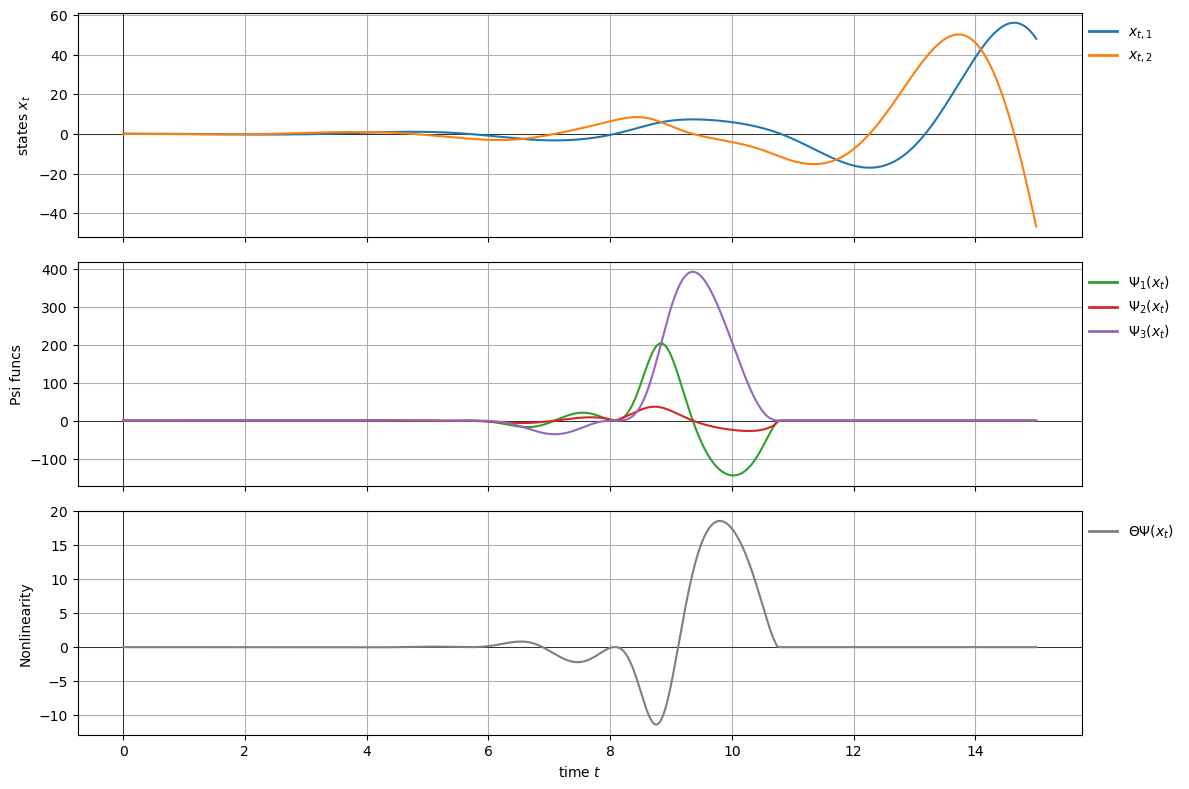

time steps: [ 0.     0.001  0.002 ... 14.998 14.999 15.   ] (15001,)
Euler integration simulation time: 0.2 sec



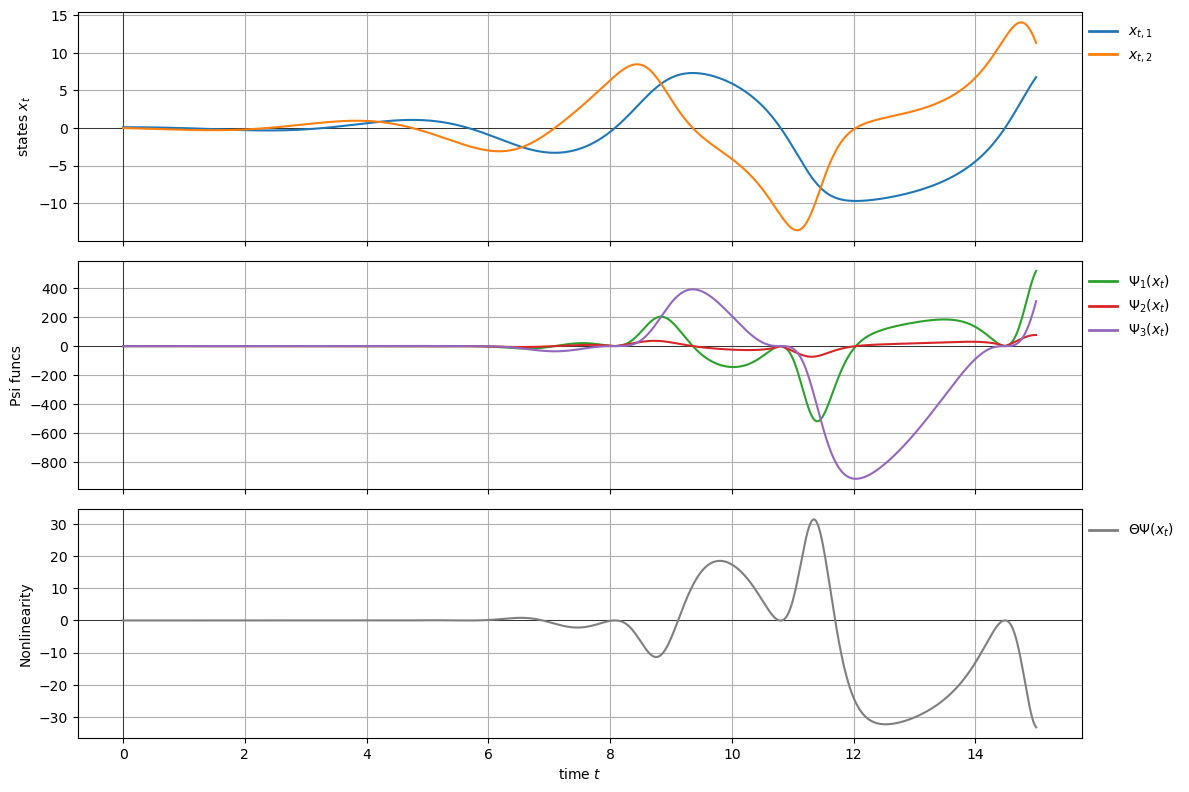

In [9]:
c24.simFullUncontrolled(A,BL,beta,PsiFunc,ThetaPsiFunc,t0 = 0,tf = 15,dt = 0.001, x0=[0.1,0.])
c24.simFullUncontrolled(A,BL,beta,PsiNBFunc,ThetaPsiNBFunc,t0 = 0,tf = 15,dt = 0.001, x0=[0.1,0.])

Now we will define the Reference system, as a 2nd order linear damped oscillator with $\omega_0=2$ rad/sec and $\xi=1$:  


$$
\begin{align*}
    \dot{x}^r_t &= A_r\ x^r_t + B_r\ r_t \\
    %           &= A\ x_t + B\ \Lambda \left(u_t + \Theta\ \Psi(x_t)\right) \\
    &= 
    \begin{bmatrix} 0 & 1 \\ -\omega_0^2 & -2\xi\omega_0 \end{bmatrix}x^r_t
    + \begin{bmatrix} 0 \\ \omega_0^2 \end{bmatrix}r_t \\
    &= 
    \begin{bmatrix} 0 & 1 \\ -4 & -4 \end{bmatrix}x^r_t
    + \begin{bmatrix} 0 \\ 4 \end{bmatrix}r_t
\end{align*} \\
$$

with $A_r$ known Hurwitz, $B_r$ known, and $r_t$ as some known, bounded reference input.

In [10]:
w0 = 2
xi = 1

Ar,Br = c24.set2ndLinDampedOsc(w0, xi)

Ar:
 [[ 0  1]
 [-4 -4]] (2, 2)
eig: [-2.+0.j -2.-0.j]
Br:
 [[0.]
 [4.]] (2, 1)


The uncontrolled linear dynamics are stable, simulating from initial $x^r_0=[1\ 1]^\top$:

time steps: [ 0.     0.001  0.002 ...  9.998  9.999 10.   ] (10001,)
Euler integration simulation time: 0.0 sec



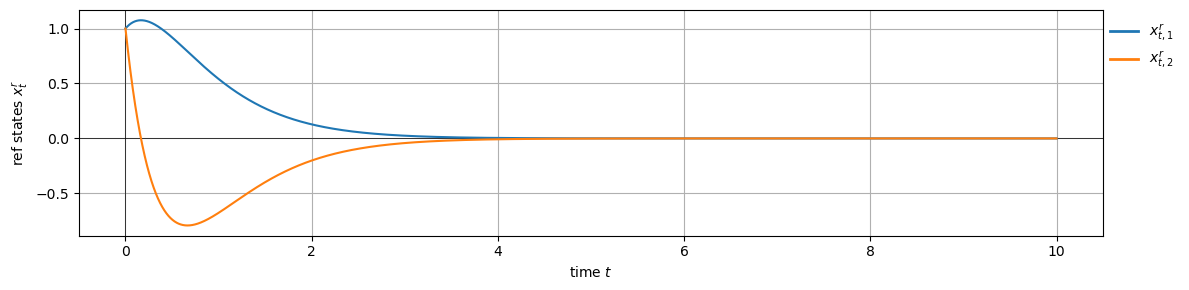

In [11]:
c24.simLinearUncontrolled(Ar,t0 = 0,tf = 10,dt = 0.001, x0=[1.,1.], Ref=True)

In our example, we can directly solve for gains $K_x,K_r$ that convert the linear component of the true platform dynamics to this linear reference system:

$$

K_x = -\frac{1}{\beta} \begin{bmatrix} \omega_0^2 - a_1 \\ 2\xi\omega_0 + 2a_2 \end{bmatrix} \qquad
K_r = \frac{\omega_0^2}{\beta}

$$

And we confirm that these satisfy the matching conditions:  

$$
\begin{align*}
A + B\Lambda K_x^\top &= A_r  \\
B\Lambda K_r^\top &= B_r 
\end{align*}
$$

In [12]:
KxT = -(1./beta) * np.array([[w0**2 + a1,
                              2*xi*w0 + a2]])
KrT = np.array([[w0**2/beta]])

print('Kx^T:\n',KxT,KxT.shape)
print('Kr^T:\n',KrT,KrT.shape)

# confirm matching conditions
print('Matching condition for A_r:',np.allclose(A + BL @ KxT,Ar))
print('Matching condition for B_r:',np.allclose(BL @ KrT,Br))

Kx^T:
 [[-2.66667 -6.66667]] (1, 2)
Kr^T:
 [[5.33333]] (1, 1)
Matching condition for A_r: True
Matching condition for B_r: True


Now we will obtain an approximation to the true $f(x)=\Theta\Psi(x)$ using randomly initialized ReLU functions:  

$$
\bm{\Theta}\bm{\Psi}(x)=\bm{\Theta}
          \begin{bmatrix} 1  \\ 
          x \\
          \sigma_{ReLU}(\bm{\alpha}_1^\top\,x - \bm{t}_1) \\ 
          \vdots \\
          \sigma_{ReLU}(\bm{\alpha}_m^\top\,x - \bm{t}_m) \end{bmatrix}
$$

where:  
$\bm{\alpha}_i \sim \mathcal{U}\!\left(\mathbb{S}^2\right)$ are drawn iid uniformly over the 2D unit sphere  
$\bm{t}_i \sim \mathcal{U}\!\left([-1,1]\right)$ are drawn iid uniformly over the interval $[-1,1]$  
$\sigma_{ReLU}()$ is the ReLU activation function of a scalar input  

Here, $\bm{\Theta}$ will be determined by least squares in the sense of trying to minimize the residuals $|f(x)-\bm{\Theta}\bm{\Psi}(x)|$,  
and we will then see the maximum $|f(x)-\bm{\Theta}\bm{\Psi}(x)|$ on a grid over the support of $\mathcal{B}(x)$ decreases as $m$ grows

In [13]:
N_m = 100 # number of times to run at each m and average results together
ms = [1,10,100,1000]
seedN = 123 # initial seed for reproducibility

for m in ms:
    print('m =',m)
    
    t0 = perf_counter()
    maxErrs_m = []
    seedN_m = []
    for Ni in range(N_m):
        PsiApprox = c24.init_Psi(m,seedN,Ni==0)
        seedN_m.append(seedN)
        seedN += 1
    
        ThetaApprox,gridErrors,maxError = c24.getThetaApprox(ThetaPsiFunc,PsiApprox,xmin=-12,xmax=12,xN=25, prtMaxErr=False)
        maxErrs_m.append(maxError)
    tf = perf_counter()
    
    print('Average over %d runs, max func approx error |f(x)-Theta@Psi(x)| over specified x grid: %.2f'%(N_m, np.mean(maxErrs_m)))
    print('Total run time with %d grid points: %.1f sec'%(gridErrors.size,tf-t0))
    # print('  time per grid point: %.4g sec'%((tf-t0)/gridErrors.size))
    print()

m = 1
Psi shape: (4, 1)
Average over 100 runs, max func approx error |f(x)-Theta@Psi(x)| over specified x grid: 77.21
Total run time with 625 grid points: 4.7 sec

m = 10
Psi shape: (13, 1)
Average over 100 runs, max func approx error |f(x)-Theta@Psi(x)| over specified x grid: 72.67
Total run time with 625 grid points: 4.8 sec

m = 100
Psi shape: (103, 1)
Average over 100 runs, max func approx error |f(x)-Theta@Psi(x)| over specified x grid: 62.41
Total run time with 625 grid points: 4.9 sec

m = 1000
Psi shape: (1003, 1)
Average over 100 runs, max func approx error |f(x)-Theta@Psi(x)| over specified x grid: 9.94
Total run time with 625 grid points: 17.5 sec



In practice with a real system, particularly for large, complex, and/or expensive platforms, it may not be feasible to query the dynamics and nonlinearity $f(x)=\Theta\Psi(x)$ at a sufficiently fine grid of $x$ states to then produce a reasonable least squares solution for $\bm{\Theta}$, as was done above.  

Instead, we can implement adaptive estimator states $\hat{\bm\Theta}$ in an MRAC control law, as described by Lavretsky chapter 12. For simplicity, we will only implement the estimator states for $\bm\Theta$ and assume we can use $K_x$ and $K_r$ directly. We will also omit the state modulation function $\mu(x)$ and state limiting control law $\tilde{u}(x)$. (See Lavretsky chapter 12 for details.)  

To do this, we must solve a Lyapunov equation for a symmetric positive definitie matrix $P$ given some symmetric positive definite matrix $Q$:

$$
A_r^\top P + PA_r = -Q
$$

In [14]:
Q = np.diag([1,10])
P = solve_continuous_lyapunov(Ar.T,-Q) # note: transpose has to be used in this scipy function!

print('Q:\n',Q,Q.shape)
print('symmetric:',np.allclose(Q,Q.T))
print('eig:',np.linalg.eig(Q)[0])
print('P:\n',P,P.shape)
print('symmetric:',np.allclose(P,P.T))
print('eig:',np.linalg.eig(P)[0])

Q:
 [[ 1  0]
 [ 0 10]] (2, 2)
symmetric: True
eig: [ 1. 10.]
P:
 [[5.625   0.125  ]
 [0.125   1.28125]] (2, 2)
symmetric: True
eig: [5.62859 1.27766]


This allows us to define the dynamics (update law) for the adaptive estimator states, as:  

$$
\dot{\hat{\bm\Theta}} = \Gamma\bm\Psi(x_t)e_t^\top PB
$$

where $e_t=x_t-x^r_t$ is the state tracking error and $\Gamma$ is a user defined symmetric positive definite matrix termed the "rates of adaptation". (See Lavretsky chapter 12 for details.) 

In [15]:
Gamma = np.diag([3,1,2])

print('Gamma:\n',Gamma,Gamma.shape)
print('symmetric:',np.allclose(Gamma,Gamma.T))
print('eig:',np.linalg.eig(Gamma)[0])

Gamma:
 [[3 0 0]
 [0 1 0]
 [0 0 2]] (3, 3)
symmetric: True
eig: [3. 1. 2.]


We will use the following bounded reference input:

$$
r_t = 10\sin(0.5t)
$$

to drive the reference system, and use a control law (see Lavretsky chapter 12 for details) of:

$$
u_t = K_x^\top x_t + K_r^\top r_t - \hat{\bm\Theta}\bm\Psi(x_t)
$$

to adaptively control the platform. We will use for $\bm\Psi$ the best performing randomly initialized function with $m=1000$ from above.

time steps: [ 0.     0.001  0.002 ... 29.998 29.999 30.   ] (30001,)


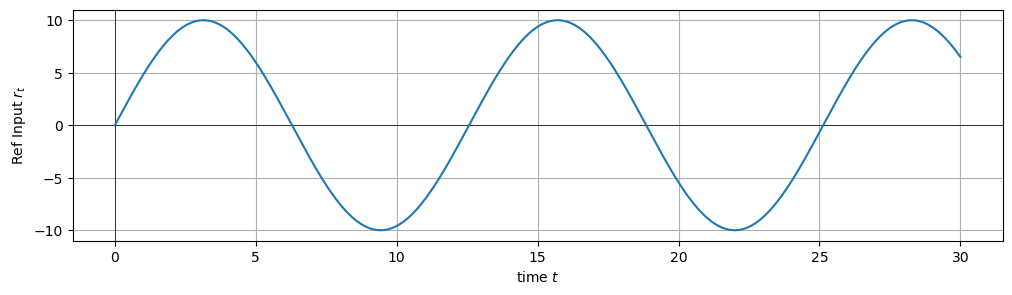

In [16]:
r = c24.setRefInput(t0 = 0,tf = 30,dt = 0.001, w = 0.5, c = 10, plot=True)

In [17]:
# here we are finding the arg for the best performing m=1000 randomly initialized Psi function, from above
maxErrs_m1000_cat = np.concatenate(maxErrs_m)
print(np.min(maxErrs_m1000_cat),np.argmin(maxErrs_m1000_cat))
argmin = np.argmin(maxErrs_m1000_cat)
for i,(m,s) in enumerate(zip(maxErrs_m1000_cat,seedN_m)):
    if i>=55 and i<=59:
        print(i,m,s)

# the seed for the best is 480, confirming the maxError is the same (it is)
PsiApprox_m1000Best = c24.init_Psi(1000,480,False)
_,_,maxError = c24.getThetaApprox(ThetaPsiFunc,PsiApprox_m1000Best,xmin=-12,xmax=12,xN=25, prtMaxErr=False)
print(maxError[0])

6.736229948955952e-06 57
55 4.605254489298918 478
56 2.581875753134554 479
57 6.736229948955952e-06 480
58 29.640895366577936 481
59 17.1294952598857 482


6.736229948955952e-06


In [12]:
# overall notebook run timer
print('Overall notebook run time: %.1f sec'%(perf_counter()-ovt0))

Overall notebook run time: 262.7 sec
